In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from pathlib import Path

import torch
from torch import save, load
import torch.nn as nn
import torch.optim as optim

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score, classification_report,roc_curve, roc_auc_score, balanced_accuracy_score

In [ ]:
!pip install fairlearn
import fairlearn

In [ ]:
from fairlearn.metrics import MetricFrame
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.metrics import true_positive_rate_difference

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from xgboost import XGBClassifier
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/Shareddrives/DS Capstone/base_baf_final.csv'
df = pd.read_csv(path)
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.250,0.986507,0.000000,0.060606,0.375,0.000086,0.918255,0.00,0.157934,...,0.0,0.685864,0.0,INTERNET,0.198216,linux,1.0,0.666667,0.0,0.0
1,0,0.875,0.617426,0.000000,0.209790,0.125,0.000129,0.114260,0.75,0.247350,...,0.0,0.685864,0.0,INTERNET,0.050217,other,1.0,0.666667,0.0,0.0
2,0,0.875,0.996708,0.026042,0.034965,0.375,0.000157,0.109273,0.25,0.163308,...,0.0,0.005236,0.0,INTERNET,0.273082,windows,0.0,0.666667,0.0,0.0
3,0,0.625,0.475100,0.031250,0.034965,0.250,0.000089,0.106372,0.25,0.519779,...,0.0,0.005236,0.0,INTERNET,0.186605,linux,1.0,0.666667,0.0,0.0
4,0,1.000,0.842307,0.000000,0.069930,0.375,0.073195,0.487853,0.00,0.349007,...,0.0,0.005236,0.0,INTERNET,0.054581,other,0.0,0.666667,0.0,0.0


In [ ]:
df["month"].unique()

array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
       0.71428571, 0.85714286, 1.        ])

In [ ]:
df.shape

(1000000, 32)

In [ ]:
df = df.drop(['source', 'device_os'], axis=1)
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.250,0.986507,0.000000,0.060606,0.375,0.000086,0.918255,0.00,0.157934,...,1.0,0.303030,0.0,0.685864,0.0,0.198216,1.0,0.666667,0.0,0.0
1,0,0.875,0.617426,0.000000,0.209790,0.125,0.000129,0.114260,0.75,0.247350,...,1.0,0.090909,0.0,0.685864,0.0,0.050217,1.0,0.666667,0.0,0.0
2,0,0.875,0.996708,0.026042,0.034965,0.375,0.000157,0.109273,0.25,0.163308,...,1.0,0.939394,0.0,0.005236,0.0,0.273082,0.0,0.666667,0.0,0.0
3,0,0.625,0.475100,0.031250,0.034965,0.250,0.000089,0.106372,0.25,0.519779,...,1.0,0.060606,0.0,0.005236,0.0,0.186605,1.0,0.666667,0.0,0.0
4,0,1.000,0.842307,0.000000,0.069930,0.375,0.073195,0.487853,0.00,0.349007,...,1.0,0.818182,0.0,0.005236,0.0,0.054581,0.0,0.666667,0.0,0.0


## Data Splits

* The goal is to create an 70/10/20 Train/Validate/Test split while maintaing a 100:1 (negative:positive) **sample ratio**.


In [ ]:
X = df.iloc[:, 1:] # features
y = df.iloc[:, 0] # fraud_bool

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=150, stratify=y) # 70/30 train/test split

In [ ]:
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=150, stratify=y_temp) # 10/20 validate /test split

In [ ]:
X_test.shape

(200000, 29)

## Base Model

In [ ]:
# Define the model and train
model = RandomForestClassifier(random_state=150)
model.fit(X_train, y_train)

# Evaluate on validation set
y_pred_validation = model.predict(X_valid)
y_proba_validation = model.predict_proba(X_valid)

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_valid, y_pred_validation)
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_valid, y_proba_validation[:, 1]) # probality of the minority positive class
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_valid, y_pred_validation)
print(f'F1 Score on the test set: {f1:.4f}')

fpr, tpr, thresholds = roc_curve(y_valid, y_proba_validation[:, 1])

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')


## Undersampling

* The original training data (sampling ratio of 100:1) will be used to perform hyperparameter tuning. We will then train the model with the best Hyperparameters and the undersampled training data.

* We undersample the training data to reflect a 1:1 **sampling ratio.** By undersampling the training data only, we can prevent the classifier from learning majority classification.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Initialize RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy=1)  # 0.2 means 5:1 ratio (negative:positive)

# Fit and apply the RandomUnderSampler to the training data
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Check the new distribution of classes
print(f"Original class distribution: {Counter(y_train)}")
print(f"Undersampled class distribution: {Counter(y_train_undersampled)}")


Original class distribution: Counter({0: 692280, 1: 7720})
Undersampled class distribution: Counter({0: 7720, 1: 7720})


## HyperParameter Tuning

In [ ]:
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, test_size=0.8, random_state=150, stratify=y_train)

In [ ]:
y_train_sample.shape

(140000,)

In [ ]:
X_calib, X_val_eval, y_calib, y_val_eval = train_test_split(
    X_valid, y_valid, test_size=0.5, stratify=y_valid, random_state=42)

In [ ]:
# Define the model
hp_model = RandomForestClassifier(random_state=150, n_jobs=-1)

# Param distribution
param_dist = {
    "n_estimators": [50, 100, 150],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

# Define scoring metrics
f1_scorer = make_scorer(f1_score, average='binary')  # F1 score for binary classification
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

# RandomizedSearchCV
random_search = RandomizedSearchCV(hp_model, param_dist, scoring=balanced_accuracy_scorer, cv=3, n_jobs=-1, n_iter=3, random_state=150,  verbose=2)

# Perform RandomSearchCV on the 10:1 sampled training data
random_search.fit(X_train_sample, y_train_sample)

# Best hyperparameters after Grid Search
best_params = random_search.best_params_
print("Best Hyperparameters:", random_search.best_params_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'entropy'}


In [ ]:
# Train the model on the undersampled training data using the best parameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train_undersampled, y_train_undersampled)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=5,
                       n_estimators=150)

In [ ]:
def find_best_threshold(y_true, y_proba):
    thresholds = [i / 100 for i in range(1, 100)]  # Thresholds from 0.01 to 0.99
    best_threshold = 0.5
    best_balanced_accuracy = 0

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(float)
        balanced_acc = balanced_accuracy_score(y_true, y_pred)

        if balanced_acc > best_balanced_accuracy:
            best_balanced_accuracy = balanced_acc
            best_threshold = threshold

    return best_threshold, best_balanced_accuracy

In [ ]:
# Evaluate on validation set
y_pred_validation = best_model.predict(X_valid)
y_proba_validation = best_model.predict_proba(X_valid)

# Find best classification threshold for Balanced Accuracy
best_threshold, best_balanced_accuracy = find_best_threshold(y_valid, y_proba_validation[:, 1])
y_pred_val = (y_proba_validation[:, 1] >= best_threshold).astype(int)

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_valid, y_pred_val)
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_valid, y_proba_validation[:, 1])
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_valid, y_pred_val)
print(f'F1 Score on the test set: {f1:.4f}')

fpr, tpr, thresholds = roc_curve(y_valid, y_proba_validation[:, 1])

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')

Balanced Accuracy on the test set: 77.88%
ROC AUC on the test set: 0.8524
F1 Score on the test set: 0.0702
TPR at FPR = 5%: 0.4234


## 4:1 undersampling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score, classification_report,roc_curve, roc_auc_score, balanced_accuracy_score

# Define the model and train
model = RandomForestClassifier(random_state=150)
model.fit(X_train_undersampled, y_train_undersampled)

# Evaluate on validation set
y_pred_validation = model.predict(X_valid)

y_proba_validation = model.predict_proba(X_valid)

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_valid, y_pred_validation)
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_valid, y_proba_validation[:, 1])
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_valid, y_pred_validation)
print(f'F1 Score on the test set: {f1:.4f}')

fpr, tpr, thresholds = roc_curve(y_valid, y_proba_validation[:, 1])

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')


## 2:1 undersampling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score, classification_report,roc_curve, roc_auc_score, balanced_accuracy_score

# Define the model and train
model = RandomForestClassifier(random_state=150)
model.fit(X_train_undersampled, y_train_undersampled)

# Evaluate on validation set
y_pred_validation = model.predict(X_valid)

y_proba_validation = model.predict_proba(X_valid)

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_valid, y_pred_validation)
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_valid, y_pred_validation)
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_valid, y_pred_validation)
print(f'F1 Score on the test set: {f1:.4f}')

# Compute ROC curve 2:1
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_validation)

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')

## 1:1 undersampling

In [ ]:
# Define the model and train
model_final = RandomForestClassifier(random_state=150)
model_final.fit(X_train_undersampled, y_train_undersampled)

# Evaluate on validation set
y_pred_validation = model_final.predict(X_valid)
y_proba_validation = model_final.predict_proba(X_valid)

# Find best classification threshold for Balanced Accuracy
best_threshold, best_balanced_accuracy = find_best_threshold(y_valid, y_proba_validation[:, 1])
y_pred_val = (y_proba_validation[:, 1] >= best_threshold).astype(int)

print(f"Best Threshold: {best_threshold}")

# Evaluation Metrics ***************************

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_valid, y_pred_val)
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_valid, y_proba_validation[:, 1])
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_valid, y_pred_val)
print(f'F1 Score on the test set: {f1:.4f}')

# Compute ROC curve 1:1
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_val)

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')

Best Threshold: 0.51
Balanced Accuracy on the test set: 79.46%
ROC AUC on the test set: 0.8673
F1 Score on the test set: 0.0804
TPR at FPR = 5%: 0.7879


In [ ]:
# Evaluate on Test Set
y_pred_temp = model_final.predict(X_test)
y_proba = model_final.predict_proba(X_test)
y_pred = (y_proba[:, 1] >= best_threshold).astype(int) # using the best classification threshold found during validation

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score on the test set: {f1:.4f}')

# Compute ROC curve 2:1
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')

Balanced Accuracy on the test set: 78.83%
ROC AUC on the test set: 0.8638
F1 Score on the test set: 0.0791
TPR at FPR = 5%: 0.7756


In [ ]:
probs_calib = model_final.predict_proba(X_calib)[:, 1]  # Probabilities of fraud
conformal_scores = np.abs(y_calib - probs_calib)

In [ ]:
alpha = 0.1
threshold = np.quantile(conformal_scores, 1 - alpha)
print("Conformal threshold (q̂):", threshold)

Conformal threshold (q̂): 0.64


In [ ]:
probs_test = model_final.predict_proba(X_test)

conformal_sets = []
for prob in probs_test:
    set_ = []
    if abs(0 - prob[0]) <= threshold:
        set_.append("0")
    if abs(1 - prob[1]) <= threshold:
        set_.append("1")
    conformal_sets.append(set_)

#Check for unique types
unique_types = set()
for types in conformal_sets:
    unique_types.update(types)
print(unique_types)



{'1', '0'}


In [ ]:
import matplotlib.pyplot as plt
from tabulate import tabulate

feature_importances = model_final.feature_importances_

# Create feature importance table
rf_feature_importance = pd.DataFrame({'Feature': df.columns[1:],'Feature Importance': feature_importances}).round(3)

# Sort by feature importance in descending order
feature_importance_df = rf_feature_importance.sort_values(by='Feature Importance', ascending=False).head(10)
print(tabulate(feature_importance_df, headers='keys', tablefmt='fancy_grid', showindex = False))



╒══════════════════════════════╤══════════════════════╕
│ Feature                      │   Feature Importance │
╞══════════════════════════════╪══════════════════════╡
│ housing_status               │                0.11  │
├──────────────────────────────┼──────────────────────┤
│ current_address_months_count │                0.069 │
├──────────────────────────────┼──────────────────────┤
│ name_email_similarity        │                0.067 │
├──────────────────────────────┼──────────────────────┤
│ credit_risk_score            │                0.067 │
├──────────────────────────────┼──────────────────────┤
│ intended_balcon_amount       │                0.05  │
├──────────────────────────────┼──────────────────────┤
│ days_since_request           │                0.043 │
├──────────────────────────────┼──────────────────────┤
│ velocity_4w                  │                0.042 │
├──────────────────────────────┼──────────────────────┤
│ velocity_6h                  │                

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


                balanced accuracy   ROC AUC  F1 Score
housing_status                                       
0.000000                 0.628413  0.628413  0.093194
0.166667                 0.724332  0.724332  0.051789
0.333333                 0.713628  0.713628  0.065880
0.500000                 0.701764  0.701764  0.047919
0.666667                 0.624328  0.624328  0.040349
0.833333                 0.942529       NaN  0.000000
1.000000                 0.914894       NaN  0.000000
Equal Opportunity Difference (TPR diff): 0.9628
Demographic Parity Difference: 0.6647
Equalized Odds Difference: 0.9628


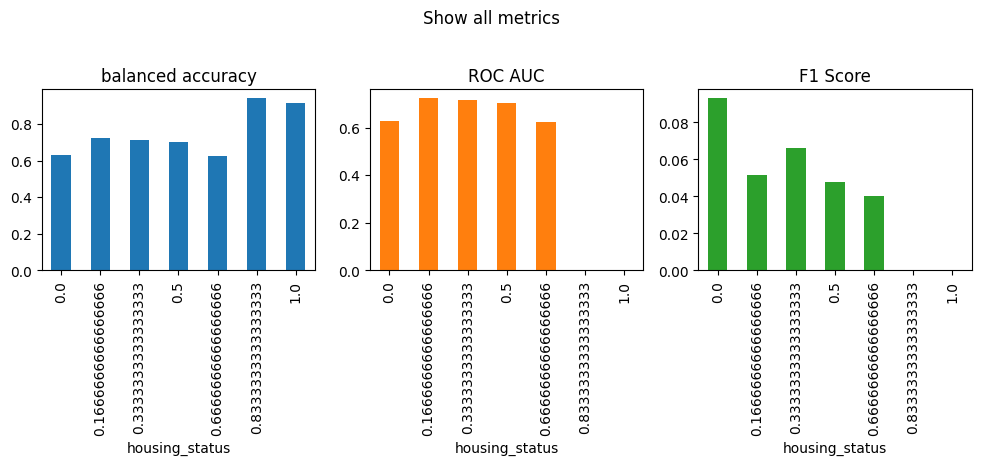

In [ ]:
#Fairlearn of Random Forest
metrics = {
    "balanced accuracy": balanced_accuracy_score,
    "ROC AUC": roc_auc_score,
    "F1 Score": f1_score
}
sensitive_feature = X_test["housing_status"]

mf = MetricFrame(metrics = metrics, y_true = y_test, y_pred = y_pred, sensitive_features = sensitive_feature)
print(mf.by_group)
mf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics"
)

tpr_diff = true_positive_rate_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)
print(f"Equal Opportunity Difference (TPR diff): {tpr_diff:.4f}")

dp_diff = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.4f}")

eodds_diff = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
print(f"Equalized Odds Difference: {eodds_diff:.4f}")

              balanced accuracy   ROC AUC  F1 Score
customer_age                                       
0.000                  0.664301  0.664301  0.039062
0.125                  0.702562  0.702562  0.055400
0.250                  0.760437  0.760437  0.066946
0.375                  0.771306  0.771306  0.070827
0.500                  0.758892  0.758892  0.090347
0.625                  0.713361  0.713361  0.116033
0.750                  0.719488  0.719488  0.135402
0.875                  0.709533  0.709533  0.161491
1.000                  0.727273  0.727273  0.250000
Equal Opportunity Difference (TPR diff): 0.6154
Demographic Parity Difference: 0.5263
Equalized Odds Difference: 0.6154


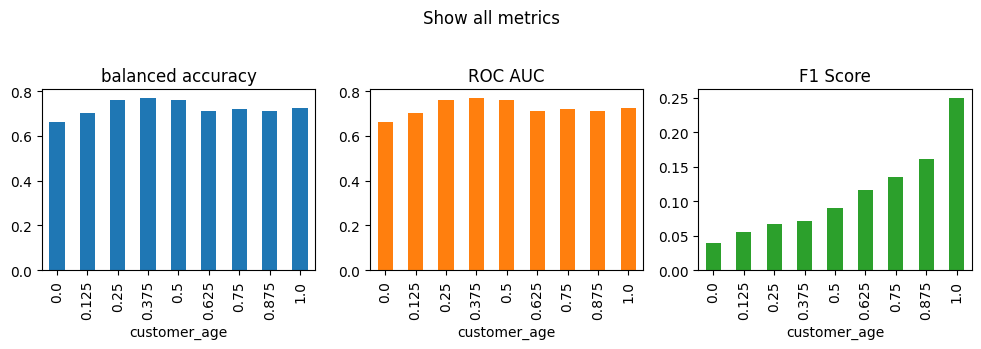

In [ ]:
metrics = {
    "balanced accuracy": balanced_accuracy_score,
    "ROC AUC": roc_auc_score,
    "F1 Score": f1_score
}
sensitive_feature = X_test["customer_age"]

mf = MetricFrame(metrics = metrics, y_true = y_test, y_pred = y_pred, sensitive_features = sensitive_feature)
print(mf.by_group)
mf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics"
)

tpr_diff = true_positive_rate_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)
print(f"Equal Opportunity Difference (TPR diff): {tpr_diff:.4f}")

dp_diff = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.4f}")

eodds_diff = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
print(f"Equalized Odds Difference: {eodds_diff:.4f}")

# Logistic Regression

lg model
predict on validation find optimal threshold
predic on test data

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Fit the model to the undersampled training data 1:1
lr_model = LogisticRegression(penalty= "l2", solver = "saga", random_state=150)
lr_model.fit(X_train_undersampled, y_train_undersampled)

# Find predicted probalities of validation set
y_proba_validation = lr_model.predict_proba(X_valid)

# Find best classification threshold for Balanced Accuracy
best_threshold, best_balanced_accuracy = find_best_threshold(y_valid, y_proba_validation[:, 1])
y_pred_val = (y_proba_validation[:, 1] >= best_threshold).astype(int)

print(f"Best Threshold: {best_threshold}")

# Evaluation Metrics ***************************

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_valid, y_pred_val)
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_valid, y_proba_validation[:, 1])
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_valid, y_pred_val)
print(f'F1 Score on the test set: {f1:.4f}')

# Compute ROC curve 1:1
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_val)

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')

Best Threshold: 0.52
Balanced Accuracy on the test set: 77.43%
ROC AUC on the test set: 0.8521
F1 Score on the test set: 0.0728
TPR at FPR = 5%: 0.7625


In [ ]:
# Evaluate on Test Set
y_pred_temp = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)
y_pred = (y_proba[:, 1] >= best_threshold).astype(int) # using the best classification threshold found during validation

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score on the test set: {f1:.4f}')

# Compute ROC curve 2:1
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')

Balanced Accuracy on the test set: 77.35%
ROC AUC on the test set: 0.8507
F1 Score on the test set: 0.0721
TPR at FPR = 5%: 0.7634


In [ ]:
# Get Coeficents
lr_features = abs(lr_model.coef_)

# Create feature importance table
lr_feature_importance = pd.DataFrame({'Feature': df.columns[1:],'Feature Coefficients': lr_features[0]}).round(3)

# Sort by feature importance in descending order
feature_importance_df = lr_feature_importance.sort_values(by='Feature Coefficients', ascending=False).head(10)
print(tabulate(feature_importance_df, headers='keys', tablefmt='fancy_grid', showindex = False))


╒══════════════════════════════════╤════════════════════════╕
│ Feature                          │   Feature Coefficients │
╞══════════════════════════════════╪════════════════════════╡
│ device_distinct_emails_8w        │                  2.569 │
├──────────────────────────────────┼────────────────────────┤
│ prev_address_months_count        │                  2.479 │
├──────────────────────────────────┼────────────────────────┤
│ housing_status                   │                  2.243 │
├──────────────────────────────────┼────────────────────────┤
│ customer_age                     │                  1.955 │
├──────────────────────────────────┼────────────────────────┤
│ credit_risk_score                │                  1.744 │
├──────────────────────────────────┼────────────────────────┤
│ employment_status                │                  1.448 │
├──────────────────────────────────┼────────────────────────┤
│ date_of_birth_distinct_emails_4w │                  1.387 │
├───────

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


                balanced accuracy   ROC AUC  F1 Score
housing_status                                       
0.000000                 0.665463  0.665463  0.105376
0.166667                 0.744408  0.744408  0.037640
0.333333                 0.715482  0.715482  0.049574
0.500000                 0.683468  0.683468  0.049853
0.666667                 0.599170  0.599170  0.052045
0.833333                 0.979885       NaN  0.000000
1.000000                 0.957447       NaN  0.000000
Equal Opportunity Difference (TPR diff): 0.9128
Demographic Parity Difference: 0.5738
Equalized Odds Difference: 0.9128


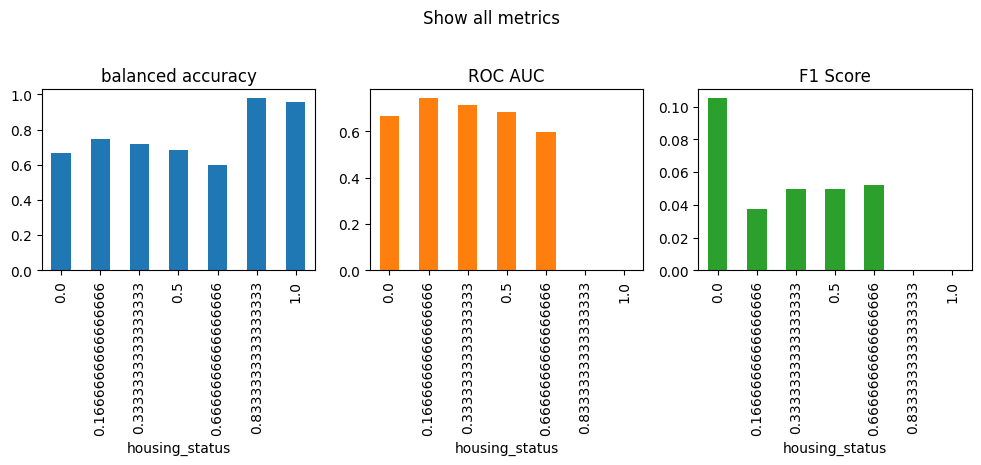

In [ ]:
#Using Fairlearn for Logistic Regression
metrics = {
    "balanced accuracy": balanced_accuracy_score,
    "ROC AUC": roc_auc_score,
    "F1 Score": f1_score
}

sensitive_feature = X_test["housing_status"]

mf = MetricFrame(metrics = metrics, y_true = y_test, y_pred = y_pred, sensitive_features = sensitive_feature)
print(mf.by_group)
mf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics"
)
tpr_diff = true_positive_rate_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)
print(f"Equal Opportunity Difference (TPR diff): {tpr_diff:.4f}")

dp_diff = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.4f}")

eodds_diff = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
print(f"Equalized Odds Difference: {eodds_diff:.4f}")

              balanced accuracy   ROC AUC  F1 Score
customer_age                                       
0.000                  0.596674  0.596674  0.034286
0.125                  0.686779  0.686779  0.052420
0.250                  0.752886  0.752886  0.061777
0.375                  0.754473  0.754473  0.062958
0.500                  0.736870  0.736870  0.081903
0.625                  0.726795  0.726795  0.118106
0.750                  0.698743  0.698743  0.127717
0.875                  0.669202  0.669202  0.138614
1.000                  0.636364  0.636364  0.200000
Equal Opportunity Difference (TPR diff): 0.7692
Demographic Parity Difference: 0.7120
Equalized Odds Difference: 0.7692


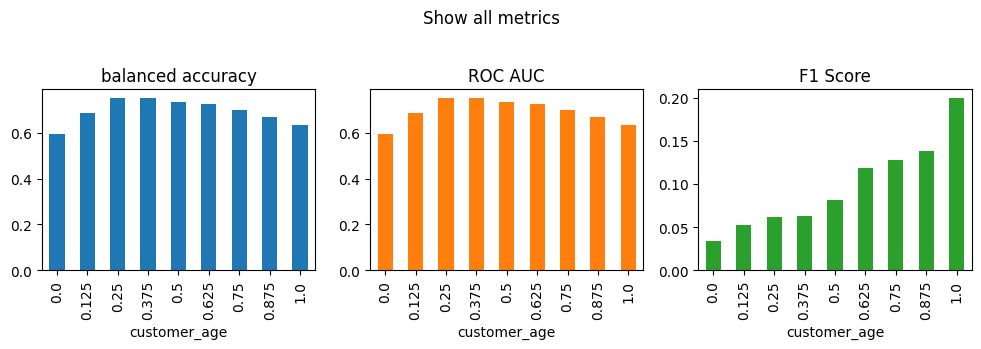

In [ ]:
sensitive_feature = X_test["customer_age"]

mf = MetricFrame(metrics = metrics, y_true = y_test, y_pred = y_pred, sensitive_features = sensitive_feature)
print(mf.by_group)
mf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics"
)
tpr_diff = true_positive_rate_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)
print(f"Equal Opportunity Difference (TPR diff): {tpr_diff:.4f}")
dp_diff = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.4f}")

eodds_diff = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
print(f"Equalized Odds Difference: {eodds_diff:.4f}")

# Multi-Layer Perceptron

In [ ]:
# (Unbalnced Calibration)
X_calibrate_base, X_train_remaining_base, y_calibrate_base, y_train_remaining_base = train_test_split(
    X_train, y_train, train_size=1000, stratify=y_train, random_state=150)

In [ ]:
# Convert base data to PyTorch tensors
X_train_base_tensor = torch.tensor(X_train_remaining_base.to_numpy(), dtype=torch.float32)
y_train_base_tensor = torch.tensor(y_train_remaining_base.to_numpy(), dtype=torch.float32)

X_validate_base_tensor = torch.tensor(X_valid.to_numpy(), dtype=torch.float32)
y_validate_base_tensor = torch.tensor(y_valid.to_numpy(), dtype=torch.float32)

X_test_base_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_base_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [ ]:
class MultiLayerPerceptron(nn.Module):

  def __init__(self, hidden_size):
    super(MultiLayerPerceptron, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(28, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1)
      )

  def forward(self, x):
    return self.layers(x)

In [ ]:
mlp_model = MultiLayerPerceptron(hidden_size = 15)
criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(mlp_model.parameters(), lr=0.001)

In [ ]:
# Model Training
epochs = 1000
for epoch in range(epochs):
  # Forward pass
  outputs = mlp_model(X_train_base_tensor)

  # Compute the loss
  y_train_base_tensor = y_train_base_tensor.view(-1, 1)
  loss = criterion(outputs, y_train_base_tensor)

  # Backward pass and optimization
  opt.zero_grad()
  loss.backward()
  opt.step()

  # Print the loss every 100 epochs
  if (epoch + 1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Evaluation on the validation set
with torch.no_grad():
    mlp_model.eval()
    outputs = mlp_model(X_validate_base_tensor)
    probabilities = torch.sigmoid(outputs)

# Find best classification threshold for Balanced Accuracy
best_threshold, best_balanced_accuracy = find_best_threshold(y_validate_base_tensor, probabilities)
y_pred_val = (probabilities >= best_threshold).float()

print(f"Best Threshold: {best_threshold}")

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_validate_base_tensor.numpy(), y_pred_val.numpy())
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_validate_base_tensor, probabilities)
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_validate_base_tensor, y_pred_val.numpy())
print(f'F1 Score on the test set: {f1:.4f}')

# Compute ROC curve 2:1
fpr, tpr, thresholds = roc_curve(y_validate_base_tensor, y_pred_val.numpy())

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')


In [ ]:
# Evaluate Test Set
with torch.no_grad():
    mlp_model.eval()
    outputs = mlp_model(X_test_base_tensor)
    probabilities = torch.sigmoid(outputs)

y_pred = (probabilities >= best_threshold).float() # using the best classification threshold found during validation

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test_base_tensor.numpy(), y_pred.numpy())
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test_base_tensor, probabilities)
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_test_base_tensor, y_pred.numpy())
print(f'F1 Score on the test set: {f1:.4f}')

# Compute ROC curve 2:1
fpr, tpr, thresholds = roc_curve(y_test_base_tensor, y_pred.numpy())

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')


In [ ]:
torch.save(mlp_model.state_dict(), "/content/drive/My Drive/DS 440/MLP_Final.pth")

# LSTM Model

In [ ]:
# Reshape input to (batch_size, seq_length=1, input_size)
X_train_base_tensor = X_train_base_tensor.unsqueeze(1)  # Adds sequence length dimension
y_train_base_tensor = y_train_base_tensor.unsqueeze(1)

X_validate_base_tensor = X_validate_base_tensor.unsqueeze(1)
y_validate_base_tensor = y_validate_base_tensor.unsqueeze(1)

X_test_base_tensor = X_test_base_tensor.unsqueeze(1)
y_test_base_tensor = y_test_base_tensor.unsqueeze(1)


In [ ]:
class LSTMAugmentedMLP(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_hidden_size, num_lstm_layers):
        super(LSTMAugmentedMLP, self).__init__()

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, num_lstm_layers, batch_first=True)

        # MLP Layers
        self.mlp = nn.Sequential(
            nn.Linear(lstm_hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        # LSTM expects input of shape (batch, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # Output shape: (batch, seq_len, lstm_hidden_size)

        # Take the output of the last time step
        last_out = lstm_out[:, -1, :]  # Shape: (batch, lstm_hidden_size)

        # Pass through the MLP
        output = self.mlp(last_out)

        return output


In [ ]:
LSTM_model = LSTMAugmentedMLP(input_size= 28, hidden_size = 15, lstm_hidden_size = 15, num_lstm_layers = 1)
criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(LSTM_model.parameters(), lr=0.001)

In [ ]:
# Model Training
epochs = 150
for epoch in range(epochs):
  # Forward pass
  outputs = LSTM_model(X_train_base_tensor)

  # Compute the loss
  y_train_base_tensor = y_train_base_tensor.view(-1, 1)
  loss = criterion(outputs, y_train_base_tensor)

  # Backward pass and optimization
  opt.zero_grad()
  loss.backward()
  opt.step()

  # Print the loss every 100 epochs
  if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Evaluation on the validation set
with torch.no_grad():
    LSTM_model.eval()
    outputs = LSTM_model(X_validate_base_tensor)
    probabilities = torch.sigmoid(outputs)

# Find best classification threshold for Balanced Accuracy
best_threshold, best_balanced_accuracy = find_best_threshold(y_validate_base_tensor, probabilities)
y_pred_val = (probabilities >= best_threshold).float()

print(f"Best Threshold: {best_threshold}")

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_validate_base_tensor.numpy(), y_pred_val.numpy())
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_validate_base_tensor, probabilities)
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_validate_base_tensor, y_pred_val.numpy())
print(f'F1 Score on the test set: {f1:.4f}')

# Compute ROC curve 2:1
fpr, tpr, thresholds = roc_curve(y_validate_base_tensor, y_pred_val.numpy())

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')


In [ ]:
# Evaluate Test Set
with torch.no_grad():
    LSTM_model.eval()
    outputs = LSTM_model(X_test_base_tensor)
    probabilities = torch.sigmoid(outputs)

y_pred = (probabilities >= best_threshold).float() # using the best classification threshold found during validation

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test_base_tensor.numpy(), y_pred.numpy())
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test_base_tensor, probabilities)
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_test_base_tensor, y_pred.numpy())
print(f'F1 Score on the test set: {f1:.4f}')

# Compute ROC curve 2:1
fpr, tpr, thresholds = roc_curve(y_test_base_tensor, y_pred.numpy())

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')


In [ ]:
class PureLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, output_size):
        super(PureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        output = self.fc(last_out)
        return output


In [ ]:
lstm_model = LSTMAugmentedMLP(input_size= 28, hidden_size = 15, lstm_hidden_size = 15, num_lstm_layers = 1)
criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(lstm_model.parameters(), lr=0.001)

In [ ]:
# Model Training
epochs = 1000
for epoch in range(epochs):
  # Forward pass
  outputs = lstm_model(X_train_base_tensor)

  # Compute the loss
  y_train_base_tensor = y_train_base_tensor.view(-1, 1)
  loss = criterion(outputs, y_train_base_tensor)

  # Backward pass and optimization
  opt.zero_grad()
  loss.backward()
  opt.step()

  # Print the loss every 100 epochs
  if (epoch + 1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Evaluation on the validation set
with torch.no_grad():
    lstm_model.eval()
    outputs = lstm_model(X_validate_base_tensor)
    probabilities = torch.sigmoid(outputs)

# Find best classification threshold for Balanced Accuracy
best_threshold, best_balanced_accuracy = find_best_threshold(y_validate_base_tensor, probabilities)
y_pred_val = (probabilities >= best_threshold).float()

print(f"Best Threshold: {best_threshold}")

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_validate_base_tensor.numpy(), y_pred_val.numpy())
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_validate_base_tensor, probabilities)
print(f'ROC AUC on the test set: {roc_auc:.4f}')

# Calculate F1 Score
f1 = f1_score(y_validate_base_tensor, y_pred_val.numpy())
print(f'F1 Score on the test set: {f1:.4f}')

# Compute ROC curve 2:1
fpr, tpr, thresholds = roc_curve(y_validate_base_tensor, y_pred_val.numpy())

# Find the threshold corresponding to FPR = 5% (0.05)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]

# Calculate TPR at that threshold
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')


# **Naive Bayes**

In [ ]:
#Using Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_valid)

#best threshold
best_threshold, best_balanced_accuracy = find_best_threshold(y_valid, y_pred)
y_pred_val = (y_pred >= best_threshold).astype(int)
print(f"Best Threshold: {best_threshold}")

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_valid, y_pred_val)
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

roc_auc = roc_auc_score(y_valid, y_pred)
print(f'ROC AUC on the test set: {roc_auc:.4f}')

f1 = f1_score(y_valid, y_pred_val)
print(f'F1 Score on the test set: {f1:.4f}')

fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')



Best Threshold: 0.01
Balanced Accuracy on the test set: 63.26%
ROC AUC on the test set: 0.6326
F1 Score on the test set: 0.0977
TPR at FPR = 5%: 0.3246


In [ ]:
#Evaluation on Test set
y_pred_temp = nb_model.predict(X_test)
y_prob = nb_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= best_threshold).astype(int)

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy on the test set: {balanced_acc:.2%}')

roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC on the test set: {roc_auc:.4f}')

f1 = f1_score(y_test, y_pred)
print(f'F1 Score on the test set: {f1:.4f}')

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
fpr_target = 0.05
threshold_at_fpr_5 = thresholds[np.where(fpr >= fpr_target)[0][0]]
tpr_at_fpr_5 = tpr[np.where(fpr >= fpr_target)[0][0]]

print(f'TPR at FPR = 5%: {tpr_at_fpr_5:.4f}')



Balanced Accuracy on the test set: 75.24%
ROC AUC on the test set: 0.8085
F1 Score on the test set: 0.0650
TPR at FPR = 5%: 0.2761
